2/18/25 

Batch Processing of flow and rain data to get ratio of flow to rain in mm/day

Use StreamStats to batch download daily mean flow with code '00060' 

In [1]:
import pandas as pd
import numpy as np
from simpledbf import Dbf5
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt
import requests
from scipy import stats
#from dataretrieval import codes, nwis, utils
from dataretrieval import nwis

GagesII has all of the NYS points, but we are only looking at 149. Read GagesII in and only keep the 149 points that we've been focused on

In [2]:
# Read in GagesII and make STAID into a str so it keeps the 0 in front of every number
gages_df = pd.read_csv('NYS_Gage_LatLong.csv', dtype={'STAID': str})
gages_df['STAID'] = gages_df['STAID'].astype(str)
print(gages_df.dtypes)
gages_df

STAID          object
LAT_GAGE      float64
LNG_GAGE      float64
DRAIN_SQKM    float64
dtype: object


,STAID,LAT_GAGE,LNG_GAGE,DRAIN_SQKM
0,01200000,41.658983,-73.528458,532.58490
1,01300000,40.983709,-73.687351,24.10380
2,01300500,40.955932,-73.718186,11.72430
3,01301000,40.954543,-73.734575,58.20592
4,01301500,40.911210,-73.813467,14.50440
...,...,...,...,...
286,04276500,44.358383,-73.396797,694.32840
287,04276842,43.942557,-73.463734,134.73900
288,04278300,43.663398,-73.603454,57.70620
289,04279000,43.843949,-73.432064,670.71960


In [3]:
# read in the wetland data from ArcGIS & flow data csv
flow = pd.read_csv('nys_gauge_mmd.csv', dtype={'STAID': str})
flow['STAID'] = flow['STAID'].astype(str) # keeps the 0 in front of the GAGE_ID
dbf = Dbf5('TabulateInter_Emergent1.dbf')
emergent = dbf.to_dataframe() # converts dbf to a dataframe
dbf1 = Dbf5('TabulateInter_ForestShrub1.dbf')
forest_shrub = dbf1.to_dataframe()
dbf2 = Dbf5('TabulateInter_FreshWPond1.dbf')
pond = dbf2.to_dataframe()
# 'Lake' and 'other' also exist but were removed because they have fewer than 150 gauge locations
# Identify the 149 common GAGE_IDs in pond, emergent, and forest_shrub
common_gage_ids = set(pond['GAGE_ID']).intersection(emergent['GAGE_ID'], forest_shrub['GAGE_ID'])
# Filter flow to match the 149 common GAGE_IDs
flow_cleaned = flow[flow['STAID'].isin(common_gage_ids)].reset_index(drop=True)
flow_cleaned

,STAID,Norm_Peak_Flow_mmd
0,01200000,13.20
1,01301000,69.09
2,01302020,39.58
3,01312000,24.12
4,01315000,7.26
...,...,...
144,04275000,40.20
145,04275500,26.61
146,04276500,17.88
147,04279000,4.52


In [4]:
# Shorten 'gages_df' to have the same amount of rows aligning with the 'STAID' column of 'flow_cleaned'
gages_df = gages_df[gages_df['STAID'].isin(flow_cleaned['STAID'])]
gages_df

,STAID,LAT_GAGE,LNG_GAGE,DRAIN_SQKM
0,01200000,41.658983,-73.528458,532.58490
3,01301000,40.954543,-73.734575,58.20592
6,01302020,40.862306,-73.874389,101.58660
30,01312000,43.966174,-74.130704,498.21930
31,01315000,43.756453,-74.267093,337.52520
...,...,...,...,...
284,04275000,44.438936,-73.681528,512.80560
285,04275500,44.451436,-73.642638,1151.83800
286,04276500,44.358383,-73.396797,694.32840
289,04279000,43.843949,-73.432064,670.71960


for one site: (FallCreek)

In [5]:
site = '04234000'
single_value = nwis.get_record(sites= site, service='dv',parameterCd='00060', start='2013-01-01', end='2023-12-31')
print(single_value.head())

                            site_no  00060_Mean 00060_Mean_cd
datetime                                                     
2013-01-01 00:00:00+00:00  04234000       188.0             A
2013-01-02 00:00:00+00:00  04234000       157.0             A
2013-01-03 00:00:00+00:00  04234000       179.0             A
2013-01-04 00:00:00+00:00  04234000       174.0             A
2013-01-05 00:00:00+00:00  04234000       166.0             A


Using STAID:

In [6]:
results = []

for i in range(len(gages_df)):
    try:
        # Use USGS site ID directly from gages_df
        #site_id = str(int(gages_df['STAID'].iloc[i]))  # Convert to string properly
        #site_id = str(gages_df['STAID'].iloc[i]).zfill(8)  # Ensures 8-digit format
        site_id = gages_df['STAID'].iloc[i]


        # Retrieve daily mean flow data (00060)
        get_flow = nwis.get_record(sites=site_id, service='dv', parameterCd='00060', start='2013-01-01')

        if get_flow.empty:
            print(f"No daily flow data for site {site_id}. Skipping.")
            continue  # Skip this site if no data is found

        # Find correct column for '00060'
        column_name = [col for col in get_flow.columns if '00060' in col]
        daily_flow_series = get_flow[column_name[0]] if column_name else pd.Series(dtype='float64')

        # Get drainage area
        cur_drainage_area = gages_df.loc[gages_df['STAID'] == site_id, 'DRAIN_SQKM']
        if cur_drainage_area.isna().any() or cur_drainage_area.empty:
            print(f"Skipping site {site_id}: Missing drainage area.")
            continue  # Skip if no valid drainage area
        
        cur_drainage_area = cur_drainage_area.iloc[0]
        normalized_flow_series = daily_flow_series / cur_drainage_area if cur_drainage_area > 0 else np.nan

        # Store results
        results.append({
            'STAID': site_id,
            'daily_flow': daily_flow_series.tolist(),  
            'normalized_daily_flow': normalized_flow_series.tolist()
        })

    except Exception as e:
        print(f"Error at site {site_id}: {e}")

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print(results_df)


No daily flow data for site 01301000. Skipping.
No daily flow data for site 01317000. Skipping.
No daily flow data for site 01372058. Skipping.
No daily flow data for site 01376500. Skipping.
        STAID                                         daily_flow  \
0    01200000  [408.0, 376.0, 345.0, 338.0, 331.0, 317.0, 307...   
1    01302020  [44.7, 40.9, 39.2, 35.8, 33.9, 32.9, 31.7, 30....   
2    01312000  [247.0, 225.0, 209.0, 204.0, 199.0, 192.0, 187...   
3    01315000  [330.0, 330.0, 330.0, 329.0, 327.0, 327.0, 327...   
4    01315500  [1140.0, 1030.0, 990.0, 1110.0, 1090.0, 1100.0...   
..        ...                                                ...   
140  04275000  [275.0, 1380.0, 1980.0, 911.0, 629.0, 494.0, 4...   
141  04275500  [350.0, 318.0, 300.0, 286.0, 272.0, 259.0, 245...   
142  04276500  [197.0, 184.0, 182.0, 171.0, 168.0, 162.0, 157...   
143  04279000  [223.0, 286.0, 283.0, 288.0, 290.0, 295.0, 298...   
144  04280450  [220.0, 185.0, 190.0, 221.0, 195.0, 184.0, 17

In [52]:
results_df

,STAID,daily_flow,normalized_daily_flow
0,01200000,"[408.0, 376.0, 345.0, 338.0, 331.0, 317.0, 307...","[0.7660750426833356, 0.7059907256101329, 0.647..."
1,01302020,"[44.7, 40.9, 39.2, 35.8, 33.9, 32.9, 31.7, 30....","[0.44001866387889743, 0.4026121555401992, 0.38..."
2,01312000,"[247.0, 225.0, 209.0, 204.0, 199.0, 192.0, 187...","[0.495765619677921, 0.4516083580062033, 0.4194..."
3,01315000,"[330.0, 330.0, 330.0, 329.0, 327.0, 327.0, 327...","[0.9777047758211832, 0.9777047758211832, 0.977..."
4,01315500,"[1140.0, 1030.0, 990.0, 1110.0, 1090.0, 1100.0...","[0.5537859772646568, 0.5003504882303478, 0.480..."
...,...,...,...
140,04275000,"[275.0, 1380.0, 1980.0, 911.0, 629.0, 494.0, 4...","[0.536265594603491, 2.6910782565557003, 3.8611..."
141,04275500,"[350.0, 318.0, 300.0, 286.0, 272.0, 259.0, 245...","[0.30386217506281266, 0.2760804904856412, 0.26..."
142,04276500,"[197.0, 184.0, 182.0, 171.0, 168.0, 162.0, 157...","[0.2837274119854524, 0.26500428327575254, 0.26..."
143,04279000,"[223.0, 286.0, 283.0, 288.0, 290.0, 295.0, 298...","[0.3324787288160358, 0.42640769704657505, 0.42..."


In [89]:
# Export results_df to a csv
results_df.to_csv("usgs_daily_flow_normalized.csv", index=False)

# Batch Precip data from DayMet

In [8]:
import requests
import pandas as pd
from tqdm import tqdm
import time

# Function to query Daymet API for daily precipitation at a given lat/lon
def get_daymet_data(lat, lon, start_year=2013, end_year=2022):
    """Fetches daily precipitation from Daymet for a given lat/lon."""
    
    url = f"https://daymet.ornl.gov/single-pixel/api/data?lat={lat}&lon={lon}&vars=prcp&start={start_year}&end={end_year}&format=json"

    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise error if request fails
        data = response.json()

        # Extract daily data
        df = pd.DataFrame(data["data"])
        df["lat"] = lat
        df["lon"] = lon
        return df

    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for {lat}, {lon}: {e}")
        return None


In [51]:
# Shorten 'gages_df' to have the same amount of rows aligning with the 'STAID' column of 'results_df' 
gages_df = gages_df[gages_df['STAID'].isin(results_df['STAID'])]
gages_df

,STAID,LAT_GAGE,LNG_GAGE,DRAIN_SQKM
0,01200000,41.658983,-73.528458,532.5849
6,01302020,40.862306,-73.874389,101.5866
30,01312000,43.966174,-74.130704,498.2193
31,01315000,43.756453,-74.267093,337.5252
32,01315500,43.700898,-73.983466,2058.5570
...,...,...,...,...
284,04275000,44.438936,-73.681528,512.8056
285,04275500,44.451436,-73.642638,1151.8380
286,04276500,44.358383,-73.396797,694.3284
289,04279000,43.843949,-73.432064,670.7196


In [11]:
# List to store all results
all_results = []

# Loop through each row in gages_df
for _, row in tqdm(gages_df.iterrows(), total=len(gages_df)):
    lat, lon = row["LAT_GAGE"], row["LNG_GAGE"]  # Ensure column names match your DataFrame
    site_id = row["STAID"]
    
    print(f"Fetching data for site {site_id} at ({lat}, {lon})")
    
    # Get precipitation data from Daymet
    df = get_daymet_data(lat, lon)
    
    if df is not None:
        df["site_id"] = site_id  # Add site ID for reference
        all_results.append(df)

    time.sleep(1)  # Add delay to avoid API rate limits

# Combine all results into one DataFrame
final_df = pd.concat(all_results, ignore_index=True)

# Save to CSV
final_df.to_csv("daymet_gages_precip.csv", index=False)

# Display first few rows
print(final_df.head())


  0%|          | 0/145 [00:00<?, ?it/s]

Fetching data for site 01200000 at (41.658983, -73.528458)


  1%|          | 1/145 [00:01<03:42,  1.55s/it]

Fetching data for site 01302020 at (40.862306, -73.874389)


  1%|▏         | 2/145 [00:03<03:39,  1.53s/it]

Fetching data for site 01312000 at (43.966174, -74.130704)


  2%|▏         | 3/145 [00:04<03:51,  1.63s/it]

Fetching data for site 01315000 at (43.756453, -74.267093)


  3%|▎         | 4/145 [00:06<03:35,  1.53s/it]

Fetching data for site 01315500 at (43.700898, -73.983466)


  3%|▎         | 5/145 [00:07<03:31,  1.51s/it]

Fetching data for site 01318500 at (43.31896, -73.844289)


  4%|▍         | 6/145 [00:09<03:24,  1.47s/it]

Fetching data for site 01321000 at (43.352847, -74.270415)


  5%|▍         | 7/145 [00:10<03:20,  1.46s/it]

Fetching data for site 01325000 at (43.31146, -73.867346)


  6%|▌         | 8/145 [00:11<03:18,  1.45s/it]

Fetching data for site 01327750 at (43.269517, -73.595949)


  6%|▌         | 9/145 [00:13<03:13,  1.42s/it]

Fetching data for site 01329490 at (43.108687, -73.421779)


  7%|▋         | 10/145 [00:14<03:14,  1.44s/it]

Fetching data for site 01330000 at (43.03063, -73.927347)


  8%|▊         | 11/145 [00:16<03:19,  1.49s/it]

Fetching data for site 01331095 at (42.935632, -73.651784)


  8%|▊         | 12/145 [00:17<03:19,  1.50s/it]

Fetching data for site 01334500 at (42.938689, -73.377056)


  9%|▉         | 13/145 [00:19<03:15,  1.48s/it]

Fetching data for site 01335754 at (42.829244, -73.666229)


 10%|▉         | 14/145 [00:21<03:21,  1.54s/it]

Fetching data for site 01336000 at (43.264514, -75.436286)


 10%|█         | 15/145 [00:22<03:14,  1.50s/it]

Fetching data for site 01346000 at (43.068959, -74.988212)


 11%|█         | 16/145 [00:23<03:15,  1.52s/it]

Fetching data for site 01347000 at (43.014793, -74.779315)


 12%|█▏        | 17/145 [00:25<03:10,  1.49s/it]

Fetching data for site 01348000 at (43.016738, -74.740702)


 12%|█▏        | 18/145 [00:26<03:06,  1.47s/it]

Fetching data for site 01349000 at (42.929517, -74.625976)


 13%|█▎        | 19/145 [00:28<03:05,  1.48s/it]

Fetching data for site 01349150 at (42.876184, -74.602919)


 14%|█▍        | 20/145 [00:29<03:03,  1.47s/it]

Fetching data for site 01349700 at (42.249253, -74.302645)


 14%|█▍        | 21/145 [00:31<03:05,  1.49s/it]

Fetching data for site 01349705 at (42.237031, -74.340147)


 15%|█▌        | 22/145 [00:32<03:08,  1.53s/it]

Fetching data for site 01349950 at (42.308418, -74.389869)


 16%|█▌        | 23/145 [00:34<03:01,  1.49s/it]

Fetching data for site 01350035 at (42.338139, -74.451537)


 17%|█▋        | 24/145 [00:35<03:00,  1.49s/it]

Fetching data for site 01350101 at (42.397303, -74.450425)


 17%|█▋        | 25/145 [00:37<03:01,  1.51s/it]

Fetching data for site 01350120 at (42.406191, -74.447091)


 18%|█▊        | 26/145 [00:38<02:57,  1.49s/it]

Fetching data for site 01350180 at (42.465911, -74.462091)


 19%|█▊        | 27/145 [00:40<02:58,  1.51s/it]

Fetching data for site 01350355 at (42.537021, -74.41042)


 19%|█▉        | 28/145 [00:41<02:54,  1.49s/it]

Fetching data for site 01351500 at (42.800075, -74.262907)


 20%|██        | 29/145 [00:43<02:51,  1.48s/it]

Fetching data for site 01357500 at (42.785356, -73.707619)


 21%|██        | 30/145 [00:44<02:47,  1.46s/it]

Fetching data for site 01358000 at (42.7523, -73.689007)


 21%|██▏       | 31/145 [00:46<02:42,  1.42s/it]

Fetching data for site 01360640 at (42.55203, -73.5915)


 22%|██▏       | 32/145 [00:47<02:45,  1.47s/it]

Fetching data for site 01362500 at (42.014259, -74.270703)


 23%|██▎       | 33/145 [00:49<02:47,  1.49s/it]

Fetching data for site 01364500 at (42.037869, -73.972081)


 23%|██▎       | 34/145 [00:50<02:45,  1.49s/it]

Fetching data for site 01365500 at (41.845092, -74.540435)


 24%|██▍       | 35/145 [00:52<02:48,  1.54s/it]

Fetching data for site 01367500 at (41.843148, -74.085976)


 25%|██▍       | 36/145 [00:53<02:40,  1.47s/it]

Fetching data for site 01372500 at (41.653149, -73.872635)


 26%|██▌       | 37/145 [00:54<02:35,  1.44s/it]

Fetching data for site 01374505 at (41.394539, -73.607072)


 26%|██▌       | 38/145 [00:56<02:33,  1.44s/it]

Fetching data for site 01374531 at (41.373778, -73.63875)


 27%|██▋       | 39/145 [00:57<02:29,  1.41s/it]

Fetching data for site 01374559 at (41.470649, -73.760132)


 28%|██▊       | 40/145 [00:59<02:25,  1.39s/it]

Fetching data for site 01374581 at (41.449816, -73.73652)


 28%|██▊       | 41/145 [01:00<02:22,  1.37s/it]

Fetching data for site 01374598 at (41.475861, -73.689472)


 29%|██▉       | 42/145 [01:01<02:19,  1.36s/it]

Fetching data for site 01374701 at (41.357872, -73.668185)


 30%|██▉       | 43/145 [01:03<02:17,  1.34s/it]

Fetching data for site 01374821 at (41.327194, -73.655833)


 30%|███       | 44/145 [01:04<02:22,  1.41s/it]

Fetching data for site 01374890 at (41.260222, -73.601861)


 31%|███       | 45/145 [01:06<02:20,  1.40s/it]

Fetching data for site 01374901 at (41.266206, -73.665685)


 32%|███▏      | 46/145 [01:07<02:16,  1.38s/it]

Fetching data for site 01374930 at (41.338139, -73.768694)


 32%|███▏      | 47/145 [01:08<02:13,  1.36s/it]

Fetching data for site 01374941 at (41.287611, -73.753639)


 33%|███▎      | 48/145 [01:10<02:12,  1.37s/it]

Fetching data for site 01375000 at (41.225094, -73.859303)


 34%|███▍      | 49/145 [01:11<02:12,  1.38s/it]

Fetching data for site 01376800 at (41.095652, -73.964027)


 34%|███▍      | 50/145 [01:12<02:10,  1.38s/it]

Fetching data for site 01387400 at (41.140373, -74.168479)


 35%|███▌      | 51/145 [01:14<02:08,  1.37s/it]

Fetching data for site 01387420 at (41.118429, -74.160145)


 36%|███▌      | 52/145 [01:15<02:08,  1.38s/it]

Fetching data for site 01387450 at (41.141111, -74.116111)


 37%|███▋      | 53/145 [01:16<02:07,  1.39s/it]

Fetching data for site 01413088 at (42.29167, -74.55972)


 37%|███▋      | 54/145 [01:18<02:06,  1.39s/it]

Fetching data for site 01413398 at (42.150922, -74.601266)


 38%|███▊      | 55/145 [01:19<02:04,  1.38s/it]

Fetching data for site 01417000 at (42.075087, -74.976275)


 39%|███▊      | 56/145 [01:21<02:05,  1.42s/it]

Fetching data for site 01417500 at (42.024809, -75.11989)


 39%|███▉      | 57/145 [01:22<02:06,  1.44s/it]

Fetching data for site 01420500 at (41.946477, -74.979609)


 40%|████      | 58/145 [01:24<02:03,  1.42s/it]

Fetching data for site 01421000 at (41.973143, -75.174058)


 41%|████      | 59/145 [01:25<02:01,  1.41s/it]

Fetching data for site 01421610 at (42.37147, -74.669042)


 41%|████▏     | 60/145 [01:26<01:58,  1.39s/it]

Fetching data for site 01421900 at (42.280362, -74.907105)


 42%|████▏     | 61/145 [01:28<02:07,  1.52s/it]

Fetching data for site 01425000 at (42.074806, -75.396009)


 43%|████▎     | 62/145 [01:30<02:04,  1.50s/it]

Fetching data for site 01426500 at (42.00314, -75.383508)


 43%|████▎     | 63/145 [01:31<02:05,  1.53s/it]

Fetching data for site 01427500 at (41.760922, -75.048223)


 44%|████▍     | 64/145 [01:33<02:00,  1.49s/it]

Fetching data for site 01428000 at (41.564256, -75.015168)


 45%|████▍     | 65/145 [01:34<01:56,  1.46s/it]

Fetching data for site 01432900 at (41.668145, -74.780441)


 46%|████▌     | 66/145 [01:35<01:54,  1.45s/it]

Fetching data for site 01433500 at (41.461481, -74.758775)


 46%|████▌     | 67/145 [01:37<01:51,  1.43s/it]

Fetching data for site 01434498 at (41.920369, -74.574601)


 47%|████▋     | 68/145 [01:38<01:49,  1.42s/it]

Fetching data for site 01436000 at (41.820091, -74.635437)


 48%|████▊     | 69/145 [01:40<01:46,  1.40s/it]

Fetching data for site 01436690 at (41.638064, -74.616883)


 48%|████▊     | 70/145 [01:41<01:45,  1.40s/it]

Fetching data for site 01437500 at (41.441204, -74.601828)


 49%|████▉     | 71/145 [01:42<01:42,  1.39s/it]

Fetching data for site 01500000 at (42.333415, -75.234894)


 50%|████▉     | 72/145 [01:44<01:44,  1.43s/it]

Fetching data for site 01500500 at (42.32147, -75.316564)


 50%|█████     | 73/145 [01:45<01:42,  1.42s/it]

Fetching data for site 01503000 at (42.035355, -75.802968)


 51%|█████     | 74/145 [01:47<01:41,  1.43s/it]

Fetching data for site 01505000 at (42.678682, -75.510457)


 52%|█████▏    | 75/145 [01:48<01:46,  1.53s/it]

Fetching data for site 01507000 at (42.324519, -75.771304)


 52%|█████▏    | 76/145 [01:50<01:43,  1.50s/it]

Fetching data for site 01509000 at (42.602848, -76.159373)


 53%|█████▎    | 77/145 [01:52<01:52,  1.66s/it]

Fetching data for site 01512500 at (42.218131, -75.84825)


 54%|█████▍    | 78/145 [01:53<01:45,  1.57s/it]

Fetching data for site 01513831 at (42.097296, -76.266322)


 54%|█████▍    | 79/145 [01:55<01:40,  1.53s/it]

Fetching data for site 01520000 at (41.99674, -77.139972)


 55%|█████▌    | 80/145 [01:56<01:38,  1.52s/it]

Fetching data for site 01520500 at (42.028685, -77.132194)


 56%|█████▌    | 81/145 [01:58<01:36,  1.52s/it]

Fetching data for site 01521500 at (42.395902, -77.711382)


 57%|█████▋    | 82/145 [01:59<01:33,  1.49s/it]

Fetching data for site 01523500 at (42.334792, -77.683048)


 57%|█████▋    | 83/145 [02:01<01:36,  1.56s/it]

Fetching data for site 01524500 at (42.313959, -77.651102)


 58%|█████▊    | 84/145 [02:02<01:34,  1.55s/it]

Fetching data for site 01525500 at (42.222295, -77.417761)


 59%|█████▊    | 85/145 [02:04<01:31,  1.52s/it]

Fetching data for site 01526500 at (42.121185, -77.129138)


 59%|█████▉    | 86/145 [02:05<01:27,  1.49s/it]

Fetching data for site 01529500 at (42.252574, -77.216642)


 60%|██████    | 87/145 [02:07<01:24,  1.45s/it]

Fetching data for site 01529950 at (42.146463, -77.057468)


 61%|██████    | 88/145 [02:08<01:20,  1.41s/it]

Fetching data for site 03011020 at (42.156452, -78.715309)


 61%|██████▏   | 89/145 [02:10<01:27,  1.56s/it]

Fetching data for site 03014500 at (42.112558, -79.203936)


 62%|██████▏   | 90/145 [02:12<01:27,  1.59s/it]

Fetching data for site 04213500 at (42.46395, -78.935035)


 63%|██████▎   | 91/145 [02:13<01:24,  1.57s/it]

Fetching data for site 04214500 at (42.854781, -78.755031)


 63%|██████▎   | 92/145 [02:15<01:36,  1.82s/it]

Fetching data for site 04215000 at (42.890059, -78.645028)


 64%|██████▍   | 93/145 [02:17<01:28,  1.71s/it]

Fetching data for site 04215500 at (42.829781, -78.775031)


 65%|██████▍   | 94/145 [02:18<01:23,  1.63s/it]

Fetching data for site 04217000 at (42.99756, -78.188628)


 66%|██████▌   | 95/145 [02:20<01:18,  1.56s/it]

Fetching data for site 04218000 at (43.093113, -78.63614)


 66%|██████▌   | 96/145 [02:21<01:14,  1.53s/it]

Fetching data for site 04218518 at (42.977836, -78.763643)


 67%|██████▋   | 97/145 [02:23<01:12,  1.52s/it]

Fetching data for site 04223000 at (42.570341, -78.042228)


 68%|██████▊   | 98/145 [02:24<01:12,  1.54s/it]

Fetching data for site 04227000 at (42.737007, -77.840558)


 68%|██████▊   | 99/145 [02:26<01:12,  1.58s/it]

Fetching data for site 04227500 at (42.766729, -77.838892)


 69%|██████▉   | 100/145 [02:27<01:09,  1.55s/it]

Fetching data for site 04227995 at (42.85389, -77.71528)


 70%|██████▉   | 101/145 [02:29<01:07,  1.53s/it]

Fetching data for site 04228500 at (42.917841, -77.757226)


 70%|███████   | 102/145 [02:30<01:04,  1.50s/it]

Fetching data for site 04229500 at (42.957285, -77.588887)


 71%|███████   | 103/145 [02:32<01:02,  1.50s/it]

Fetching data for site 04230380 at (42.744228, -78.137511)


 72%|███████▏  | 104/145 [02:33<01:00,  1.48s/it]

Fetching data for site 04230500 at (43.010062, -77.791395)


 72%|███████▏  | 105/145 [02:35<00:58,  1.47s/it]

Fetching data for site 04231000 at (43.100617, -77.882232)


 73%|███████▎  | 106/145 [02:36<00:57,  1.48s/it]

Fetching data for site 04231600 at (43.141722, -77.616306)


 74%|███████▍  | 107/145 [02:38<00:57,  1.52s/it]

Fetching data for site 04232034 at (43.027841, -77.47805)


 74%|███████▍  | 108/145 [02:39<00:54,  1.48s/it]

Fetching data for site 04232050 at (43.130341, -77.518608)


 75%|███████▌  | 109/145 [02:41<00:52,  1.46s/it]

Fetching data for site 04232482 at (42.680348, -76.953852)


 76%|███████▌  | 110/145 [02:42<00:51,  1.47s/it]

Fetching data for site 04234000 at (42.453406, -76.472717)


 77%|███████▋  | 111/145 [02:44<00:49,  1.46s/it]

Fetching data for site 04235250 at (42.957842, -77.068027)


 77%|███████▋  | 112/145 [02:45<00:47,  1.45s/it]

Fetching data for site 04237500 at (43.157012, -76.331598)


 78%|███████▊  | 113/145 [02:46<00:45,  1.42s/it]

Fetching data for site 04239000 at (42.983399, -76.150758)


 79%|███████▊  | 114/145 [02:48<00:43,  1.42s/it]

Fetching data for site 04240010 at (43.057567, -76.162425)


 79%|███████▉  | 115/145 [02:49<00:41,  1.39s/it]

Fetching data for site 04240100 at (43.0359, -76.181592)


 80%|████████  | 116/145 [02:50<00:40,  1.40s/it]

Fetching data for site 04240120 at (43.077289, -76.170203)


 81%|████████  | 117/145 [02:52<00:38,  1.38s/it]

Fetching data for site 04240180 at (42.9209, -76.329376)


 81%|████████▏ | 118/145 [02:53<00:37,  1.40s/it]

Fetching data for site 04240300 at (43.0809, -76.226316)


 82%|████████▏ | 119/145 [02:55<00:35,  1.38s/it]

Fetching data for site 04242500 at (43.301736, -75.618793)


 83%|████████▎ | 120/145 [02:56<00:34,  1.38s/it]

Fetching data for site 04243500 at (43.097569, -75.63907)


 83%|████████▎ | 121/145 [02:57<00:33,  1.40s/it]

Fetching data for site 04247000 at (43.205068, -76.217705)


 84%|████████▍ | 122/145 [02:59<00:31,  1.39s/it]

Fetching data for site 04249000 at (43.451735, -76.505219)


 85%|████████▍ | 123/145 [03:00<00:30,  1.38s/it]

Fetching data for site 04250200 at (43.533403, -76.038533)


 86%|████████▌ | 124/145 [03:02<00:29,  1.39s/it]

Fetching data for site 04250750 at (43.813398, -76.074646)


 86%|████████▌ | 125/145 [03:03<00:27,  1.38s/it]

Fetching data for site 04252500 at (43.511736, -75.30656)


 87%|████████▋ | 126/145 [03:04<00:26,  1.37s/it]

Fetching data for site 04258000 at (43.897291, -75.404075)


 88%|████████▊ | 127/145 [03:06<00:24,  1.37s/it]

Fetching data for site 04260500 at (43.985616, -75.924646)


 88%|████████▊ | 128/145 [03:07<00:23,  1.36s/it]

Fetching data for site 04262000 at (44.222562, -75.074365)


 89%|████████▉ | 129/145 [03:09<00:22,  1.43s/it]

Fetching data for site 04262500 at (44.185619, -75.330759)


 90%|████████▉ | 130/145 [03:10<00:22,  1.48s/it]

Fetching data for site 04263000 at (44.599506, -75.378829)


 90%|█████████ | 131/145 [03:12<00:20,  1.46s/it]

Fetching data for site 04266500 at (44.234783, -74.571841)


 91%|█████████ | 132/145 [03:13<00:19,  1.47s/it]

Fetching data for site 04267500 at (44.51173, -74.882972)


 92%|█████████▏| 133/145 [03:15<00:17,  1.46s/it]

Fetching data for site 04268000 at (44.838941, -74.978813)


 92%|█████████▏| 134/145 [03:16<00:16,  1.46s/it]

Fetching data for site 04269000 at (44.863664, -74.778801)


 93%|█████████▎| 135/145 [03:18<00:14,  1.47s/it]

Fetching data for site 04270000 at (44.756161, -74.218771)


 94%|█████████▍| 136/145 [03:19<00:13,  1.46s/it]

Fetching data for site 04270200 at (44.940045, -74.556299)


 94%|█████████▍| 137/145 [03:20<00:11,  1.45s/it]

Fetching data for site 04271500 at (45.000038, -73.500972)


 95%|█████████▌| 138/145 [03:22<00:10,  1.54s/it]

Fetching data for site 04271815 at (44.902262, -73.415135)


 96%|█████████▌| 139/145 [03:24<00:09,  1.53s/it]

Fetching data for site 04273500 at (44.68171, -73.471246)


 97%|█████████▋| 140/145 [03:25<00:07,  1.49s/it]

Fetching data for site 04275000 at (44.438936, -73.681528)


 97%|█████████▋| 141/145 [03:27<00:06,  1.51s/it]

Fetching data for site 04275500 at (44.451436, -73.642638)


 98%|█████████▊| 142/145 [03:28<00:04,  1.49s/it]

Fetching data for site 04276500 at (44.358383, -73.396797)


 99%|█████████▊| 143/145 [03:29<00:02,  1.49s/it]

Fetching data for site 04279000 at (43.843949, -73.432064)


 99%|█████████▉| 144/145 [03:32<00:01,  1.66s/it]

Fetching data for site 04280450 at (43.463959, -73.284276)


100%|██████████| 145/145 [03:33<00:00,  1.47s/it]


     year  yday  prcp (mm/day)        lat        lon   site_id
0  1980.0   1.0            0.0  41.658983 -73.528458  01200000
1  1980.0   2.0            0.0  41.658983 -73.528458  01200000
2  1980.0   3.0            0.0  41.658983 -73.528458  01200000
3  1980.0   4.0            0.0  41.658983 -73.528458  01200000
4  1980.0   5.0            0.0  41.658983 -73.528458  01200000


If you don't want to run the above again:

In [74]:
daymet = pd.read_csv("daymet_gages_precip.csv", dtype={'site_id': str})
daymet

,year,yday,prcp (mm/day),lat,lon,site_id
0,1980.0,1.0,0.00,41.658983,-73.528458,01200000
1,1980.0,2.0,0.00,41.658983,-73.528458,01200000
2,1980.0,3.0,0.00,41.658983,-73.528458,01200000
3,1980.0,4.0,0.00,41.658983,-73.528458,01200000
4,1980.0,5.0,0.00,41.658983,-73.528458,01200000
...,...,...,...,...,...,...
2328695,2023.0,361.0,6.19,43.463959,-73.284276,04280450
2328696,2023.0,362.0,2.43,43.463959,-73.284276,04280450
2328697,2023.0,363.0,5.67,43.463959,-73.284276,04280450
2328698,2023.0,364.0,1.37,43.463959,-73.284276,04280450


In [ ]:
# Slice the DataFrame from that index onward
daymet2 = daymet.loc[daymet['year']>=2013,:]
daymet2

,year,yday,prcp (mm/day),lat,lon,site_id
12045,2013.0,1.0,0.00,41.658983,-73.528458,01200000
12046,2013.0,2.0,0.00,41.658983,-73.528458,01200000
12047,2013.0,3.0,0.00,41.658983,-73.528458,01200000
12048,2013.0,4.0,0.00,41.658983,-73.528458,01200000
12049,2013.0,5.0,0.00,41.658983,-73.528458,01200000
...,...,...,...,...,...,...
2328695,2023.0,361.0,6.19,43.463959,-73.284276,04280450
2328696,2023.0,362.0,2.43,43.463959,-73.284276,04280450
2328697,2023.0,363.0,5.67,43.463959,-73.284276,04280450
2328698,2023.0,364.0,1.37,43.463959,-73.284276,04280450


In [85]:
# Get the list of site IDs in results_df
valid_site_ids = set(results_df['STAID'].unique())

# Keep only the rows in filtered_df that have matching site_ids in results_df
filtered_df1 = filtered_df[filtered_df['site_id'].isin(valid_site_ids)].copy()
filtered_df2 = filtered_df1.loc[filtered_df1['year']>=2013,:]

filtered_df2

,year,yday,prcp (mm/day),lat,lon,site_id
0,2013.0,1.0,0.00,41.658983,-73.528458,01200000
1,2013.0,2.0,0.00,41.658983,-73.528458,01200000
2,2013.0,3.0,0.00,41.658983,-73.528458,01200000
3,2013.0,4.0,0.00,41.658983,-73.528458,01200000
4,2013.0,5.0,0.00,41.658983,-73.528458,01200000
...,...,...,...,...,...,...
3505090,2023.0,361.0,6.19,43.463959,-73.284276,04280450
3505091,2023.0,362.0,2.43,43.463959,-73.284276,04280450
3505092,2023.0,363.0,5.67,43.463959,-73.284276,04280450
3505093,2023.0,364.0,1.37,43.463959,-73.284276,04280450


Note: If we want to use the same 149 stations, we need to take out the 4 stations from the filtered_df dataset that have no daily flow data

Need to turn the flow dataset from row based lists to columns.

 Data from USGS and Daymet do different things with leap years- USGS has extra rows of data, so add NaN values to the USGS data (flow)

In [ ]:
# Expand the flow dataset (results_df)

# Generate year and yday values, correctly handling leap years
date_list = []
for year in range(2013, 2024):  # 2013 to 2023
    if year in [2016, 2020]:  # Leap years
        days = list(range(1, 367))  # 366 days
    else:
        days = list(range(1, 366))  # 365 days
    date_list.extend([(year, day) for day in days])

# Create DataFrame with correct leap year handling
dates = pd.DataFrame(date_list, columns=['year', 'yday'])

# Validate total number of days
expected_length = sum(366 if year in [2016, 2020] else 365 for year in range(2013, 2024))  # 4018
actual_length = len(dates)
assert actual_length == expected_length, f"Expected {expected_length} days, got {actual_length}"

# Expand results_df while correctly matching leap years
expanded_data = []

for _, row in results_df.iterrows():
    station_id = str(row['STAID']).zfill(8)  # Preserve leading zeros
    daily_flow_values = row['daily_flow'][:expected_length]  # Trim to 4018 days if necessary
    normalized_flow_values = row['normalized_daily_flow'][:expected_length]
    
    # Append structured records
    expanded_data.extend(zip(
        dates['year'], dates['yday'], [station_id] * expected_length, daily_flow_values, normalized_flow_values
    ))

# Convert list to DataFrame
expanded_results_df = pd.DataFrame(expanded_data, columns=['year', 'yday', 'site_id', 'daily_flow', 'normalized_daily_flow'])
expanded_results_df


,year,yday,site_id,daily_flow,normalized_daily_flow
0,2013,1,01200000,408.0,0.766075
1,2013,2,01200000,376.0,0.705991
2,2013,3,01200000,345.0,0.647784
3,2013,4,01200000,338.0,0.634641
4,2013,5,01200000,331.0,0.621497
...,...,...,...,...,...
557339,2023,361,04280450,543.0,1.246469
557340,2023,362,04280450,550.0,1.262538
557341,2023,363,04280450,508.0,1.166126
557342,2023,364,04280450,640.0,1.469135


In [67]:
print("Unique site_id format in filtered_df1:")
print(filtered_df1['site_id'].astype(str).str[:10].unique())

print("\nUnique STAID format in results_df:")
print(results_df['STAID'].astype(str).str[:10].unique())


Unique site_id format in filtered_df1:
['01200000' '01302020' '01312000' '01315000' '01315500' '01318500'
 '01321000' '01325000' '01327750' '01329490' '01330000' '01331095'
 '01334500' '01335754' '01336000' '01346000' '01347000' '01348000'
 '01349000' '01349150' '01349700' '01349705' '01349950' '01350035'
 '01350101' '01350120' '01350180' '01350355' '01351500' '01357500'
 '01358000' '01360640' '01362500' '01364500' '01365500' '01367500'
 '01372500' '01374505' '01374531' '01374559' '01374581' '01374598'
 '01374701' '01374821' '01374890' '01374901' '01374930' '01374941'
 '01375000' '01376800' '01387400' '01387420' '01387450' '01413088'
 '01413398' '01417000' '01417500' '01420500' '01421000' '01421610'
 '01421900' '01425000' '01426500' '01427500' '01428000' '01432900'
 '01433500' '01434498' '01436000' '01436690' '01437500' '01500000'
 '01500500' '01503000' '01505000' '01507000' '01509000' '01512500'
 '01513831' '01520000' '01520500' '01521500' '01523500' '01524500'
 '01525500' '01526500' 

In [56]:

# Generate year and yday values (ignoring leap years)
years = np.repeat(np.arange(2013, 2024), 365)  # Repeat each year 365 times
ydays = np.tile(np.arange(1, 366), 11)  # Repeat 1-365 for 11 years

# Create DataFrame without dates
dates = pd.DataFrame({'year': years, 'yday': ydays})

# Ensure only 4015 entries (ignoring leap days)
dates = dates.iloc[:4015]

# Expand results_df without handling leap years
expanded_data = []

for _, row in results_df.iterrows():
    station_id = str(row['STAID']).zfill(8)  # Ensure leading zeros remain (string format)
    daily_flow_values = row['daily_flow'][:4015]  # Trim to 4015 days if necessary
    normalized_flow_values = row['normalized_daily_flow'][:4015]
    
    # Append structured records
    expanded_data.extend(zip(
        dates['year'], dates['yday'], [station_id] * len(dates), daily_flow_values, normalized_flow_values
    ))

# Convert list to DataFrame
expanded_results_df = pd.DataFrame(expanded_data, columns=['year', 'yday', 'site_id', 'daily_flow', 'normalized_daily_flow'])

# Ensure site_id in filtered_df is also treated as a string
filtered_df['site_id'] = filtered_df['site_id'].astype(str).str.zfill(8)

# Merge with filtered_df to align formats
final_df = filtered_df.merge(expanded_results_df, on=['year', 'yday', 'site_id'], how='left')
final_df


,year,yday,prcp (mm/day),lat,lon,site_id,daily_flow,normalized_daily_flow
0,2013.0,1.0,0.00,41.658983,-73.528458,01200000,408.0,0.766075
1,2013.0,2.0,0.00,41.658983,-73.528458,01200000,376.0,0.705991
2,2013.0,3.0,0.00,41.658983,-73.528458,01200000,345.0,0.647784
3,2013.0,4.0,0.00,41.658983,-73.528458,01200000,338.0,0.634641
4,2013.0,5.0,0.00,41.658983,-73.528458,01200000,331.0,0.621497
...,...,...,...,...,...,...,...,...
3505090,2023.0,361.0,6.19,43.463959,-73.284276,04280450,541.0,1.241878
3505091,2023.0,362.0,2.43,43.463959,-73.284276,04280450,495.0,1.136284
3505092,2023.0,363.0,5.67,43.463959,-73.284276,04280450,543.0,1.246469
3505093,2023.0,364.0,1.37,43.463959,-73.284276,04280450,550.0,1.262538


In [68]:
# Generate year and yday values (ignoring leap years)
years = np.repeat(np.arange(2013, 2024), 365)  # Repeat each year 365 times
ydays = np.tile(np.arange(1, 366), 11)  # Repeat 1-365 for 11 years

# Create DataFrame without dates
dates = pd.DataFrame({'year': years, 'yday': ydays})

# Ensure only 4015 entries (ignoring leap days)
dates = dates.iloc[:4015]

# Expand results_df without handling leap years
expanded_data = []

for _, row in results_df.iterrows():
    station_id = str(row['STAID']).zfill(8)  # Ensure leading zeros remain (string format)
    daily_flow_values = row['daily_flow'][:4015]  # Trim to 4015 days if necessary
    normalized_flow_values = row['normalized_daily_flow'][:4015]
    
    # Append structured records
    expanded_data.extend(zip(
        dates['year'], dates['yday'], [station_id] * len(dates), daily_flow_values, normalized_flow_values
    ))

# Convert list to DataFrame
expanded_results_df = pd.DataFrame(expanded_data, columns=['year', 'yday', 'site_id', 'daily_flow', 'normalized_daily_flow'])

# Ensure site_id in filtered_df1 is also treated as a string
filtered_df1['site_id'] = filtered_df1['site_id'].astype(str).str.zfill(8)

# Merge with filtered_df1 to align formats
final_df = filtered_df1.merge(expanded_results_df, on=['year', 'yday', 'site_id'], how='left')
final_df

,year,yday,prcp (mm/day),lat,lon,site_id,daily_flow,normalized_daily_flow
0,2013.0,1.0,0.00,41.658983,-73.528458,01200000,408.0,0.766075
1,2013.0,2.0,0.00,41.658983,-73.528458,01200000,376.0,0.705991
2,2013.0,3.0,0.00,41.658983,-73.528458,01200000,345.0,0.647784
3,2013.0,4.0,0.00,41.658983,-73.528458,01200000,338.0,0.634641
4,2013.0,5.0,0.00,41.658983,-73.528458,01200000,331.0,0.621497
...,...,...,...,...,...,...,...,...
2316650,2023.0,361.0,6.19,43.463959,-73.284276,04280450,541.0,1.241878
2316651,2023.0,362.0,2.43,43.463959,-73.284276,04280450,495.0,1.136284
2316652,2023.0,363.0,5.67,43.463959,-73.284276,04280450,543.0,1.246469
2316653,2023.0,364.0,1.37,43.463959,-73.284276,04280450,550.0,1.262538


In [34]:
# Step 1: Initialize an empty list to store results
expanded_rows = []

# Function to determine if a year is a leap year
def is_leap_year(year):
    return (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0)

# Function to assign correct year and yday values
def assign_years(start_year, total_days):
    current_year = start_year
    current_yday = 1
    year_yday_pairs = []

    for _ in range(total_days):
        year_yday_pairs.append((current_year, current_yday))
        current_yday += 1
        # Check if we need to reset yday and increment year
        if (is_leap_year(current_year) and current_yday > 366) or (not is_leap_year(current_year) and current_yday > 365):
            current_year += 1
            current_yday = 1  # Reset day counter

    return year_yday_pairs

# Step 2: Process each row
for _, row in results_df.iterrows():
    staid = row["STAID"]
    daily_flow_list = row["daily_flow"]
    normalized_flow_list = row["normalized_daily_flow"]
    start_year = row.get("start_year", 2013)  

    # Ensure lists are valid
    if isinstance(daily_flow_list, list) and isinstance(normalized_flow_list, list):
        total_days = len(daily_flow_list)  # Number of daily values
        year_yday_list = assign_years(start_year, total_days)  # Get correct year/yday pairs

        # Append processed data
        for (year, yday), flow, norm_flow in zip(year_yday_list, daily_flow_list, normalized_flow_list):
            expanded_rows.append([staid, year, yday, flow, norm_flow])

# Step 3: Convert list into a DataFrame
flow_long = pd.DataFrame(expanded_rows, columns=["STAID", "Year", "yday", "daily_flow", "normalized_daily_flow"])


In [ ]:
# Step 1: Initialize an empty list to store results
expanded_rows = []

# Step 2: Process each row individually (avoiding large memory usage)
for _, row in results_df.iterrows():
    staid = row["STAID"]
    daily_flow_list = row["daily_flow"]
    normalized_flow_list = row["normalized_daily_flow"]
    
    # Ensure these are lists before proceeding
    if isinstance(daily_flow_list, list) and isinstance(normalized_flow_list, list):
        for day, (flow, norm_flow) in enumerate(zip(daily_flow_list, normalized_flow_list), start=1):
            expanded_rows.append([staid, day, flow, norm_flow])

# Step 3: Convert list into a DataFrame (this avoids kernel crashes)
flow_long = pd.DataFrame(expanded_rows, columns=["STAID", "yday", "daily_flow", "normalized_daily_flow"])

Processing STAID 04280450, start_year 2013, 4439 days


In [38]:
print(flow_long.tail())

           STAID  yday  daily_flow  normalized_daily_flow
610985  04280450  4435   -999999.0           -2295.520563
610986  04280450  4436   -999999.0           -2295.520563
610987  04280450  4437   -999999.0           -2295.520563
610988  04280450  4438   -999999.0           -2295.520563
610989  04280450  4439   -999999.0           -2295.520563


In [43]:
# Step 4: Convert to numeric values
flow_long["daily_flow"] = pd.to_numeric(flow_long["daily_flow"], errors="coerce")
flow_long["normalized_daily_flow"] = pd.to_numeric(flow_long["normalized_daily_flow"], errors="coerce")

# Step 6: Merge flow data with precipitation data
#rename site_id column to STAID
# Convert STAID and yday to string in both DataFrames to ensure compatibility
flow_long["STAID"] = flow_long["STAID"].astype(str)
flow_long["yday"] = flow_long["yday"].astype(int)  # Ensure yday is integer

filtered_df["STAID"] = filtered_df["STAID"].astype(str)
filtered_df["yday"] = filtered_df["yday"].astype(int)  # Ensure yday is integer

# Now perform the merge
merged_df = pd.merge(flow_long, filtered_df, on=["STAID", "yday"], how="inner")
#filtered_df.rename(columns={'site_id': 'STAID'}, inplace=True)
#merged_df = pd.merge(flow_long, filtered_df, on=["STAID", "yday"], how="inner")

# Step 7: Compute flow-to-precipitation ratio
merged_df["flow_precip_ratio"] = merged_df["daily_flow"] / merged_df["prcp (mm/day)"]
merged_df.replace([np.inf, -np.inf], np.nan, inplace=True)  # Remove infinite values
merged_df.fillna(0, inplace=True)  # Replace NaNs with 0 (if necessary)

# Display first few rows
print(merged_df.head())


Empty DataFrame
Columns: [STAID, yday, daily_flow, normalized_daily_flow, year, prcp (mm/day), lat, lon, flow_precip_ratio]
Index: []


In [47]:
print(assign_years(2013, 10))  # Test function with sample data


[(2013, 1), (2013, 2), (2013, 3), (2013, 4), (2013, 5), (2013, 6), (2013, 7), (2013, 8), (2013, 9), (2013, 10)]


In [44]:
print(results_df.shape)
print(results_df.head())

(145, 3)
      STAID                                         daily_flow  \
0  01200000  [408.0, 376.0, 345.0, 338.0, 331.0, 317.0, 307...   
1  01302020  [44.7, 40.9, 39.2, 35.8, 33.9, 32.9, 31.7, 30....   
2  01312000  [247.0, 225.0, 209.0, 204.0, 199.0, 192.0, 187...   
3  01315000  [330.0, 330.0, 330.0, 329.0, 327.0, 327.0, 327...   
4  01315500  [1140.0, 1030.0, 990.0, 1110.0, 1090.0, 1100.0...   

                               normalized_daily_flow  
0  [0.7660750426833356, 0.7059907256101329, 0.647...  
1  [0.44001866387889743, 0.4026121555401992, 0.38...  
2  [0.495765619677921, 0.4516083580062033, 0.4194...  
3  [0.9777047758211832, 0.9777047758211832, 0.977...  
4  [0.5537859772646568, 0.5003504882303478, 0.480...  


In [45]:
print(results_df.dtypes)
print(results_df.iloc[0])  # Check first row for issues


STAID                    object
daily_flow               object
normalized_daily_flow    object
dtype: object
STAID                                                             01200000
daily_flow               [408.0, 376.0, 345.0, 338.0, 331.0, 317.0, 307...
normalized_daily_flow    [0.7660750426833356, 0.7059907256101329, 0.647...
Name: 0, dtype: object


In [ ]:
flow_long

Find the ratio of flow to precip

In [69]:
# Avoid division by zero by replacing 0 precipitation values with NaN (optional: could use a small value instead)
final_df['prcp (mm/day)'] = final_df['prcp (mm/day)'].replace(0, np.nan)

# Compute the ratio of normalized flow to precipitation
final_df['flow_precip_ratio'] = final_df['normalized_daily_flow'] / final_df['prcp (mm/day)']

# Fill NaN values with 0 (optional, depending on how you want to handle division by zero)
final_df['flow_precip_ratio'] = final_df['flow_precip_ratio'].fillna(0)
final_df

,year,yday,prcp (mm/day),lat,lon,site_id,daily_flow,normalized_daily_flow,flow_precip_ratio
0,2013.0,1.0,NaN,41.658983,-73.528458,01200000,408.0,0.766075,0.000000
1,2013.0,2.0,NaN,41.658983,-73.528458,01200000,376.0,0.705991,0.000000
2,2013.0,3.0,NaN,41.658983,-73.528458,01200000,345.0,0.647784,0.000000
3,2013.0,4.0,NaN,41.658983,-73.528458,01200000,338.0,0.634641,0.000000
4,2013.0,5.0,NaN,41.658983,-73.528458,01200000,331.0,0.621497,0.000000
...,...,...,...,...,...,...,...,...,...
2316650,2023.0,361.0,6.19,43.463959,-73.284276,04280450,541.0,1.241878,0.200626
2316651,2023.0,362.0,2.43,43.463959,-73.284276,04280450,495.0,1.136284,0.467606
2316652,2023.0,363.0,5.67,43.463959,-73.284276,04280450,543.0,1.246469,0.219836
2316653,2023.0,364.0,1.37,43.463959,-73.284276,04280450,550.0,1.262538,0.921560


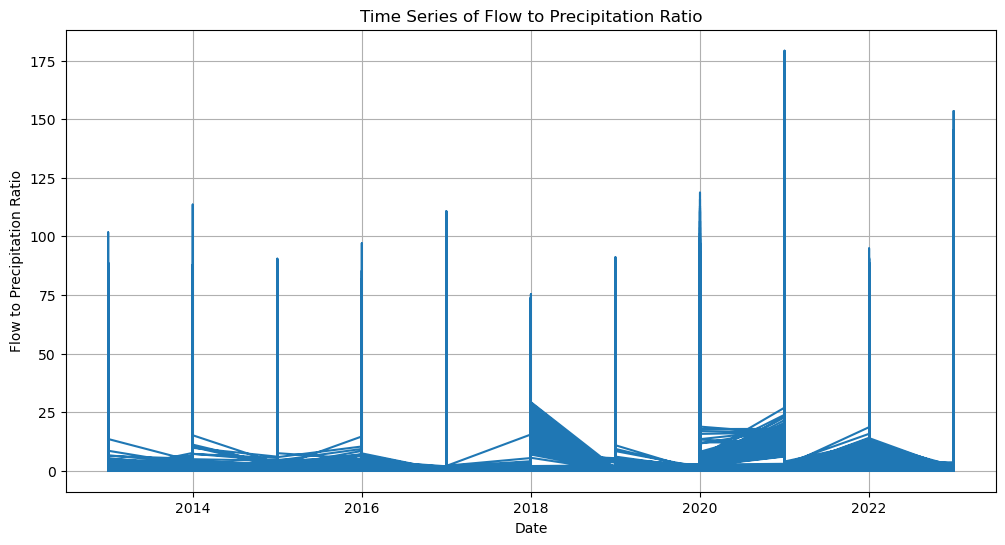

In [88]:
# Create the time series plot
plt.figure(figsize=(12, 6))
plt.plot(daymet2['year'], daymet2['prcp (mm/day)'])
plt.xlabel("Date")
plt.ylabel("Flow to Precipitation Ratio")
plt.title("Time Series of Flow to Precipitation Ratio")
plt.grid(True)
plt.show()